# Machine Learning Course Project
## Team C3
## Intel Image Classification (CNN - Keras)

1. Firstly, we'll import usefull packages.
1. Then, we'll load the data, before visualize and preprocess it.
1. We'll try a simple CNN model and then we will evaluate its performances.
1. And finally, we'll use techniques such as data augmentation, learning rate decay and dropout to increase our model's accuracy.

## Import Packages

In [1]:
import numpy as np                          # linear algebra
import os                                   # used for loading the data
from sklearn.metrics import confusion_matrix# confusion matrix to carry out error analysis
import seaborn as sn                        # heatmap
from sklearn.utils import shuffle           # shuffle the data
import matplotlib.pyplot as plt             # 2D plotting library
import cv2                                  # image processing library
import tensorflow as tf                     # best library ever
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
# Here's our 6 categories that we have to classify.
class_names = ['mountain', 'street', 'glacier', 'buildings', 'sea', 'forest']
class_names_label = {'mountain': 0,
                    'street' : 1,
                    'glacier' : 2,
                    'buildings' : 3,
                    'sea' : 4,
                    'forest' : 5
                    }
nb_classes = 6

## Loading the Data
We have to write a load_data function that load the images and the labels from the folder.

In [3]:
def load_data():
    """
        Load the data:
            - 14,034 images to train the network.
            - 10,000 images to evaluate how accurately the network learned to classify images.
    """
    
    datasets = ['intel-image-classification/seg_train/seg_train', 'intel-image-classification/seg_test/seg_test']
    size = (150,150)
    output = []
    for dataset in datasets:
        directory = "../input/" + dataset
        images = []
        labels = []
        for folder in os.listdir(directory):
            curr_label = class_names_label[folder]
            for file in os.listdir(directory + "/" + folder):
                img_path = directory + "/" + folder + "/" + file
                curr_img = cv2.imread(img_path)
                curr_img = cv2.resize(curr_img, size)
                images.append(curr_img)
                labels.append(curr_label)
        images, labels = shuffle(images, labels)     ### Shuffle the data !!!
        images = np.array(images, dtype = 'float32') ### Our images
        labels = np.array(labels, dtype = 'int32')   ### From 0 to num_classes-1!
        
        output.append((images, labels))

    return output

In [4]:
(train_images, train_labels), (test_images, test_labels) = load_data()

## Dataset Exploration

* How many training and testing examples do we have ?
* What is the size of the images ?
* What is the proportion of each observed category ?

In [5]:
print ("Number of training examples: " + str(train_labels.shape[0]))
print ("Number of testing examples: " + str(test_labels.shape[0]))
print ("Each image is of size: " + str(train_images.shape[1:]))

Number of training examples: 14034
Number of testing examples: 3000
Each image is of size: (150, 150, 3)


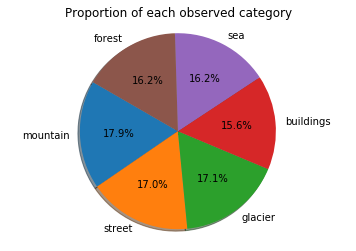

In [6]:
# Plot a pie chart
sizes = np.bincount(train_labels)
explode = (0, 0, 0, 0, 0, 0)
plt.pie(sizes, explode=explode, labels=class_names,
autopct='%1.1f%%', shadow=True, startangle=150)
plt.axis('equal')
plt.title('Proportion of each observed category')

plt.show()

## Scaling the data

In [7]:
train_images = train_images / 255.0 
test_images = test_images / 255.0

## What an image looks like ???
Let's display a random image from the training set.

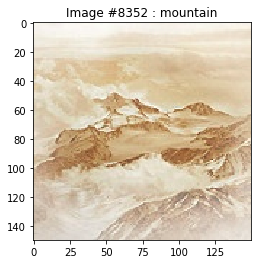

In [8]:
index = np.random.randint(train_images.shape[0])
plt.figure()
plt.imshow(train_images[index])
plt.grid(False)
plt.title('Image #{} : '.format(index) + class_names[train_labels[index]])
plt.show()

We can also display the first 25 images from the training set directly.

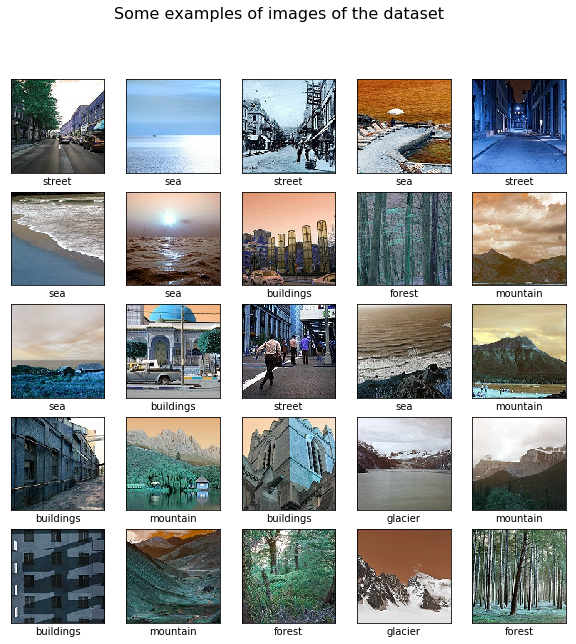

In [9]:
fig = plt.figure(figsize=(10,10))
fig.suptitle("Some examples of images of the dataset", fontsize=16)
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

## Create Model

Steps are:
1. Build the model,
1. Compile the model,
1. Train / fit the data to the model,
1. Evaluate the model on the testing set,
1. Carry out an error analysis of our model.

We can build an easy model composed of different layers such as:
* Conv2D: (32 filters of size 3 by 3) The features will be "extracted" from the image.
* MaxPooling2D: The images get half sized.
* Flatten: Transforms the format of the images from a 2d-array to a 1d-array of 150 150 3 pixel values.
* Relu  : given a value x, returns max(x, 0).
* Softmax: 6 neurons, probability that the image belongs to one of the classes.

In [10]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (150, 150, 3)), # the nn will learn the good filter to use
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(42, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(42, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(42, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(6, activation=tf.nn.softmax)
])

Then, we can compile it with some parameters such as:
* **Optimizer**: adam = RMSProp + Momentum.
What is Momentum and RMSProp ?
* Momentum = takes into account past gradient to have a better update.
* RMSProp = exponentially weighted average of the squares of past gradients.
* **Loss function**: we use sparse categorical crossentropy for classification, each images belongs to one class only

In [11]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 42)        12138     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 42)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 42)        15918     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 42)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 42)        1

We fit the model to the data from the training set. The neural network will learn by itself the pattern in order to distinguish each category.

In [13]:
history = model.fit(train_images, train_labels, batch_size=128, epochs=9, validation_split = 0.2)

Train on 11227 samples, validate on 2807 samples
Epoch 1/9
11227/11227 [==============================] - 11s 985us/sample - loss: 1.1806 - accuracy: 0.5228 - val_loss: 0.9445 - val_accuracy: 0.6284
Epoch 2/9
11227/11227 [==============================] - 5s 450us/sample - loss: 0.8970 - accuracy: 0.6606 - val_loss: 0.8425 - val_accuracy: 0.6680
Epoch 3/9
11227/11227 [==============================] - 5s 454us/sample - loss: 0.7680 - accuracy: 0.7172 - val_loss: 0.6612 - val_accuracy: 0.7563
Epoch 4/9
11227/11227 [==============================] - 5s 452us/sample - loss: 0.6757 - accuracy: 0.7546 - val_loss: 0.6065 - val_accuracy: 0.7624
Epoch 5/9
11227/11227 [==============================] - 5s 454us/sample - loss: 0.5792 - accuracy: 0.7894 - val_loss: 0.5434 - val_accuracy: 0.7976
Epoch 6/9
11227/11227 [==============================] - 5s 449us/sample - loss: 0.5433 - accuracy: 0.8076 - val_loss: 0.5377 - val_accuracy: 0.7976
Epoch 7/9
11227/11227 [==============================] -

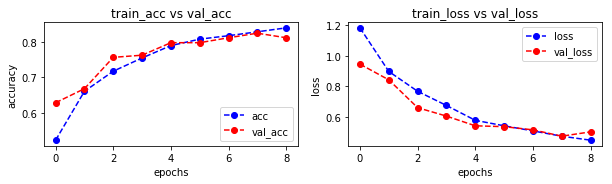

In [14]:
fig = plt.figure(figsize=(10,5))
plt.subplot(221)
plt.plot(history.history['accuracy'],'bo--', label = "acc")
plt.plot(history.history['val_accuracy'], 'ro--', label = "val_acc")
plt.title("train_acc vs val_acc")
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.legend()

plt.subplot(222)
plt.plot(history.history['loss'],'bo--', label = "loss")
plt.plot(history.history['val_loss'], 'ro--', label = "val_loss")
plt.title("train_loss vs val_loss")
plt.ylabel("loss")
plt.xlabel("epochs")


plt.legend()
plt.show()

## How well the model is doing ?

In [15]:
test_loss = model.evaluate(test_images, test_labels)

3000/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

We see that we achieve **0.82 accuracy** on the testing test.
We can see how the classifier is doing on random images.

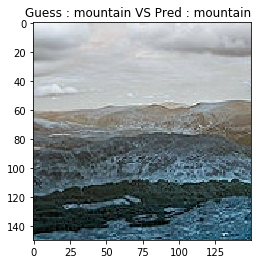

In [16]:
index = np.random.randint(test_images.shape[0]) # We choose a random index

img = (np.expand_dims(test_images[index], 0))
predictions = model.predict(img)     # Vector of probabilities
pred_img = np.argmax(predictions[0]) # We take the highest probability
pred_label = class_names[pred_img]
true_label = class_names[test_labels[index]] 

title = 'Guess : {} VS Pred : {}  '.format(pred_label , true_label )

plt.figure()
plt.imshow(test_images[index])
plt.grid(False)
plt.title(title)
plt.show()

We can try to see on which kind of images the classifier has trouble.

In [17]:
def print_mislabeled_images(class_names, test_images, test_labels, pred_labels):
    """
        Print 25 examples of mislabeled images by the classifier, e.g when test_labels != pred_labels
    """
    BOO = (test_labels == pred_labels)
    mislabeled_indices = np.where(BOO == 0)
    mislabeled_images = test_images[mislabeled_indices]
    mislabeled_labels = pred_labels[mislabeled_indices]
    fig = plt.figure(figsize=(10,10))
    fig.suptitle("Some examples of mislabeled images by the classifier:", fontsize=16)
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(mislabeled_images[i], cmap=plt.cm.binary)
        plt.xlabel(class_names[mislabeled_labels[i]])
    plt.show()

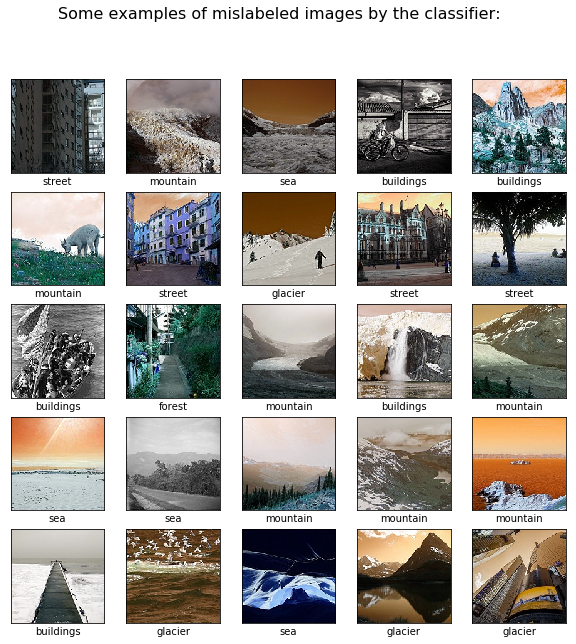

In [18]:
predictions = model.predict(test_images)
pred_labels = np.argmax(predictions, axis = 1)
print_mislabeled_images(class_names, test_images, test_labels, pred_labels)

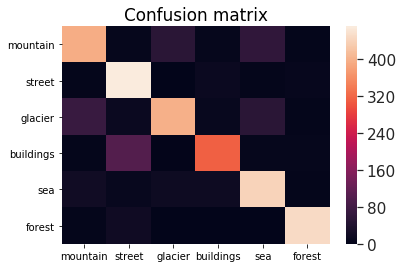

In [19]:
CM = confusion_matrix(test_labels, pred_labels)
ax = plt.axes()
sn.set(font_scale=1.4)
sn.heatmap(CM, annot=False,annot_kws={"size": 16},  xticklabels=class_names, yticklabels=class_names, ax = ax)
ax.set_title('Confusion matrix')
plt.show()

## Time to improve the model :)
### We'll use the followings techniques:
 * Data augmentation,
 * Dropout,
 * Adding more layers.

## Creating a new network with Dropouts

Another technique to reduce overfitting is to introduce dropout to the network. It is a form of regularization that forces the weights in the network to take only small values, which makes the distribution of weight values more regular and the network can reduce overfitting on small training examples.

When appling 0.1 dropout to a certain layer, it randomly kills 10% of the output units in each training epoch.

In [20]:
model_new = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (150, 150, 3)), # the nn will learn the good filter to use
    tf.keras.layers.MaxPooling2D(2,2),
    Dropout(0.2),
    tf.keras.layers.Conv2D(42, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(42, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(42, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(6, activation=tf.nn.softmax)
])

In [21]:
model_new.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model_new.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 72, 72, 42)        12138     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 36, 36, 42)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 34, 34, 42)        15918     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 17, 17, 42)       

In [22]:
history = model_new.fit(train_images, train_labels, batch_size=128, epochs=12, validation_split = 0.2)

Train on 11227 samples, validate on 2807 samples
Epoch 1/12
11227/11227 [==============================] - 6s 563us/sample - loss: 1.2984 - accuracy: 0.4772 - val_loss: 1.0224 - val_accuracy: 0.6014
Epoch 2/12
11227/11227 [==============================] - 5s 487us/sample - loss: 0.9481 - accuracy: 0.6364 - val_loss: 0.9059 - val_accuracy: 0.6516
Epoch 3/12
11227/11227 [==============================] - 5s 483us/sample - loss: 0.7766 - accuracy: 0.7111 - val_loss: 0.7106 - val_accuracy: 0.7496
Epoch 4/12
11227/11227 [==============================] - 5s 480us/sample - loss: 0.6768 - accuracy: 0.7554 - val_loss: 0.6812 - val_accuracy: 0.7417
Epoch 5/12
11227/11227 [==============================] - 5s 483us/sample - loss: 0.6461 - accuracy: 0.7644 - val_loss: 0.6641 - val_accuracy: 0.7431
Epoch 6/12
11227/11227 [==============================] - 5s 469us/sample - loss: 0.5672 - accuracy: 0.7946 - val_loss: 0.5830 - val_accuracy: 0.7866
Epoch 7/12
11227/11227 [===========================

In [23]:
test_loss = model_new.evaluate(test_images, test_labels)

3000/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

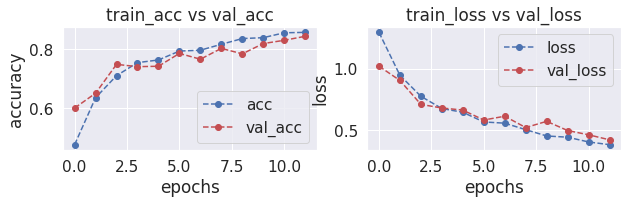

In [24]:
fig = plt.figure(figsize=(10,5))
plt.subplot(221)
plt.plot(history.history['accuracy'],'bo--', label = "acc")
plt.plot(history.history['val_accuracy'], 'ro--', label = "val_acc")
plt.title("train_acc vs val_acc")
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.legend()

plt.subplot(222)
plt.plot(history.history['loss'],'bo--', label = "loss")
plt.plot(history.history['val_loss'], 'ro--', label = "val_loss")
plt.title("train_loss vs val_loss")
plt.ylabel("loss")
plt.xlabel("epochs")


plt.legend()
plt.show()

### Dropout enhanced our accuracy to 0.8273

## Data augmentation

Overfitting generally occurs when there are a small number of training examples. One way to fix this problem is to augment the dataset so that it has a sufficient number of training examples. Data augmentation takes the approach of generating more training data from existing training samples by augmenting the samples using random transformations that yield believable-looking images.

In [25]:
batch_size = 128
epochs = 9
IMG_HEIGHT = 150
IMG_WIDTH = 150

### Create training data generator
Here, we applied rescale, 45 degree rotation, width shift, height shift, horizontal flip and zoom augmentation to the training images.

In [26]:
image_gen_train = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=45,
                    width_shift_range=.15,
                    height_shift_range=.15,
                    horizontal_flip=True,
                    zoom_range=0.5
                    )

In [27]:
train_data_gen = image_gen_train.flow_from_directory('../input/intel-image-classification/seg_train/seg_train',
                                                     batch_size=batch_size,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')

Found 14034 images belonging to 6 classes.


### Create validation data generator

In [28]:
image_gen_val = ImageDataGenerator(rescale=1./255)

In [29]:
val_data_gen = image_gen_val.flow_from_directory('../input/intel-image-classification/seg_test/seg_test',
                                                 batch_size=batch_size,
                                                 target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                 class_mode='binary')

Found 3000 images belonging to 6 classes.


In [30]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (150, 150, 3)), # the nn will learn the good filter to use
    tf.keras.layers.MaxPooling2D(2,2),
    Dropout(0.2),
    tf.keras.layers.Conv2D(42, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(42, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(42, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(6, activation=tf.nn.softmax)
])

In [31]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 72, 72, 42)        12138     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 36, 36, 42)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 34, 34, 42)        15918     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 17, 17, 42)       

In [32]:
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=14034 // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=3000 // batch_size
)

Epoch 1/9
109/109 [==============================] - 102s 933ms/step - loss: 1.3601 - accuracy: 0.4525 - val_loss: 1.2664 - val_accuracy: 0.4976
Epoch 2/9
109/109 [==============================] - 101s 923ms/step - loss: 1.1138 - accuracy: 0.5630 - val_loss: 1.0697 - val_accuracy: 0.5954
Epoch 3/9
109/109 [==============================] - 101s 927ms/step - loss: 1.0325 - accuracy: 0.6089 - val_loss: 0.9460 - val_accuracy: 0.6396
Epoch 4/9
109/109 [==============================] - 101s 928ms/step - loss: 0.9627 - accuracy: 0.6421 - val_loss: 1.0207 - val_accuracy: 0.6172
Epoch 5/9
109/109 [==============================] - 99s 913ms/step - loss: 0.9228 - accuracy: 0.6547 - val_loss: 0.7527 - val_accuracy: 0.7374
Epoch 6/9
109/109 [==============================] - 99s 908ms/step - loss: 0.8884 - accuracy: 0.6675 - val_loss: 0.9063 - val_accuracy: 0.6664
Epoch 7/9
109/109 [==============================] - 100s 913ms/step - loss: 0.8543 - accuracy: 0.6793 - val_loss: 0.7061 - val_accu

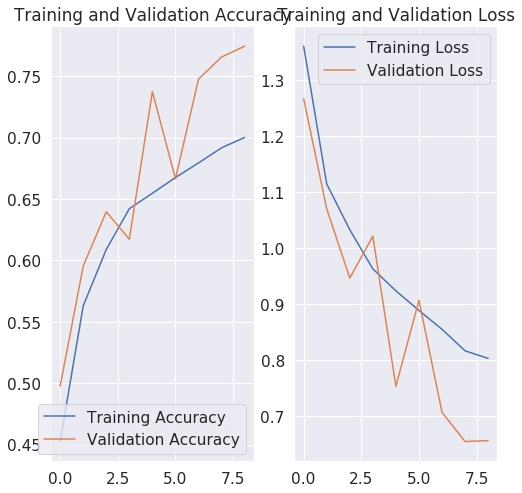

In [33]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Adding more layers and varying learning rate of adam optimizer

In [34]:
import tensorflow.keras.layers as Layers
import tensorflow.keras.activations as Actications
import tensorflow.keras.models as Models
import tensorflow.keras.optimizers as Optimizer
import tensorflow.keras.metrics as Metrics
import tensorflow.keras.utils as Utils
from keras.utils.vis_utils import model_to_dot
import os
import matplotlib.pyplot as plot
import cv2
import numpy as np
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix as CM
from random import randint
from IPython.display import SVG
import matplotlib.gridspec as gridspec

Using TensorFlow backend.


In [35]:
model = Models.Sequential()

model.add(Layers.Conv2D(200,kernel_size=(3,3),activation='relu',input_shape=(150,150,3)))
model.add(Layers.Conv2D(180,kernel_size=(3,3),activation='relu'))
model.add(Layers.MaxPool2D(5,5))
model.add(Layers.Conv2D(180,kernel_size=(3,3),activation='relu'))
model.add(Layers.Conv2D(140,kernel_size=(3,3),activation='relu'))
model.add(Layers.Conv2D(100,kernel_size=(3,3),activation='relu'))
model.add(Layers.Conv2D(50,kernel_size=(3,3),activation='relu'))
model.add(Layers.MaxPool2D(5,5))
model.add(Layers.Flatten())
model.add(Layers.Dense(180,activation='relu'))
model.add(Layers.Dense(100,activation='relu'))
model.add(Layers.Dense(50,activation='relu'))
model.add(Layers.Dropout(rate=0.5))
model.add(Layers.Dense(6,activation='softmax'))

In [36]:
model.compile(optimizer=Optimizer.Adam(lr=0.0001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [37]:
trained = model.fit(train_images, train_labels,epochs=35,validation_split=0.30)

Train on 9823 samples, validate on 4211 samples
Epoch 1/35
9823/9823 [==============================] - 50s 5ms/sample - loss: 1.4069 - accuracy: 0.4143 - val_loss: 1.0858 - val_accuracy: 0.5557
Epoch 2/35
9823/9823 [==============================] - 47s 5ms/sample - loss: 1.1588 - accuracy: 0.5523 - val_loss: 0.9499 - val_accuracy: 0.6345
Epoch 3/35
9823/9823 [==============================] - 47s 5ms/sample - loss: 1.0701 - accuracy: 0.5945 - val_loss: 0.8991 - val_accuracy: 0.6604
Epoch 4/35
9823/9823 [==============================] - 47s 5ms/sample - loss: 0.9899 - accuracy: 0.6289 - val_loss: 0.8348 - val_accuracy: 0.6875
Epoch 5/35
9823/9823 [==============================] - 47s 5ms/sample - loss: 0.9089 - accuracy: 0.6647 - val_loss: 0.7603 - val_accuracy: 0.7110
Epoch 6/35
9823/9823 [==============================] - 47s 5ms/sample - loss: 0.8351 - accuracy: 0.7011 - val_loss: 0.6884 - val_accuracy: 0.7483
Epoch 7/35
9823/9823 [==============================] - 47s 5ms/sample

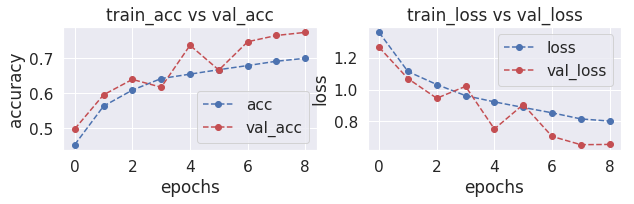

In [38]:
fig = plt.figure(figsize=(10,5))
plt.subplot(221)
plt.plot(history.history['accuracy'],'bo--', label = "acc")
plt.plot(history.history['val_accuracy'], 'ro--', label = "val_acc")
plt.title("train_acc vs val_acc")
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.legend()

plt.subplot(222)
plt.plot(history.history['loss'],'bo--', label = "loss")
plt.plot(history.history['val_loss'], 'ro--', label = "val_loss")
plt.title("train_loss vs val_loss")
plt.ylabel("loss")
plt.xlabel("epochs")


plt.legend()
plt.show()

In [39]:
test_loss = model.evaluate(test_images, test_labels)

3000/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

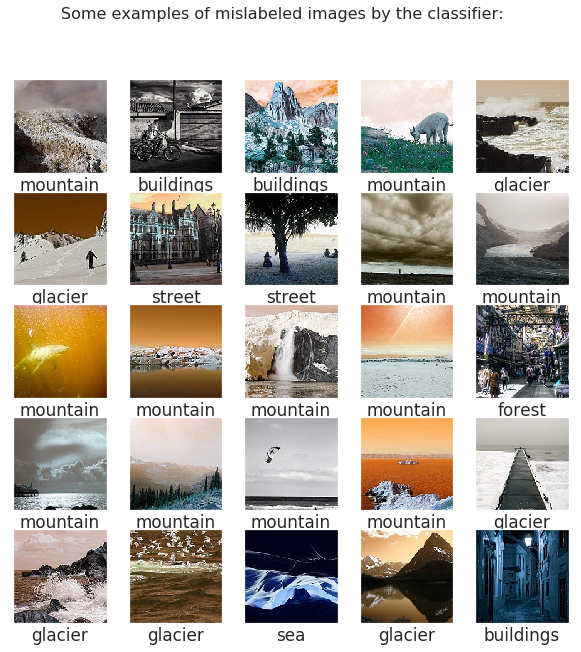

In [40]:
predictions = model.predict(test_images)
pred_labels = np.argmax(predictions, axis = 1)
print_mislabeled_images(class_names, test_images, test_labels, pred_labels)

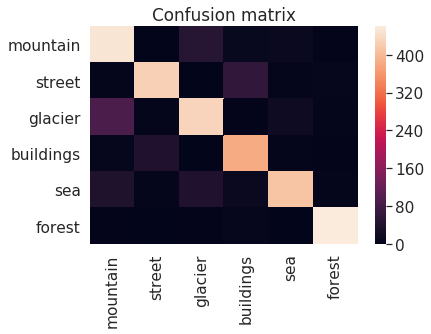

In [41]:
CM = confusion_matrix(test_labels, pred_labels)
ax = plt.axes()
sn.set(font_scale=1.4)
sn.heatmap(CM, annot=False,annot_kws={"size": 16},  xticklabels=class_names, yticklabels=class_names, ax = ax)
ax.set_title('Confusion matrix')
plt.show()

* This enhanced our accuracy to **0.8600**